<a href="https://colab.research.google.com/github/sanvirrafsaan/Data-Science-Portfolio/blob/main/Churn-prediction/notebooks/02_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import sys
from pathlib import Path

%cd /content
!rm -rf Data-Science-Portfolio
!git clone -q https://github.com/sanvirrafsaan/Data-Science-Portfolio.git
%cd /content/Data-Science-Portfolio/Churn-prediction

assert Path("pyproject.toml").exists()
assert Path("src/churn").exists()

!{sys.executable} -m pip -q install -e . --no-cache-dir

# Add the src directory to sys.path so the 'churn' module can be found
sys.path.insert(0, str(Path("src").resolve()))

import churn
from churn import utils, paths
print("✅ churn:", churn.__file__)
print("✅ utils:", utils.__file__)
print("✅ paths:", paths.__file__)

/content
/content/Data-Science-Portfolio/Churn-prediction
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for churn (pyproject.toml) ... done
✅ churn: /content/Data-Science-Portfolio/Churn-prediction/src/churn/__init__.py
✅ utils: /content/Data-Science-Portfolio/Churn-prediction/src/churn/utils.py
✅ paths: /content/Data-Science-Portfolio/Churn-prediction/src/churn/paths.py


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor
from churn.utils import best_grid_shape
from churn.paths import RAW_DIR, INTERIM_DIR

In [ ]:
import os
from pathlib import Path

# --- Detect environment ---
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    pass

# --- Project root ---
if IN_COLAB:
    drive.mount('/content/drive')
    PROJECT_ROOT = Path("/content/drive/MyDrive/Data Science Portfolio/churn-prediction")
else:
    PROJECT_ROOT = Path("/Users/user/Desktop/data-science-projects/Data-Science-Portfolio/churn-prediction")

# --- Paths ---
RAW_DIR = PROJECT_ROOT / "data" / "raw"
INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

# --- Ensure directories exist ---
for p in [RAW_DIR, INTERIM_DIR, PROCESSED_DIR, MODELS_DIR, FIGURES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# --- Debug ---
print("Running in Colab:", IN_COLAB)
print("Project root:", PROJECT_ROOT)
print("Interim contents:", [x.name for x in INTERIM_DIR.iterdir()])


Mounted at /content/drive
Running in Colab: True
Project root: /content/drive/MyDrive/Data Science Portfolio/churn-prediction
Interim contents: ['interim_data.parquet']


In [ ]:
df = pd.read_parquet(f"{INTERIM_DIR}/interim_data.parquet")
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   Tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

In [ ]:
df['Contract'].unique()

['Month-to-month', 'One year', 'Two year']
Categories (3, object): ['Month-to-month', 'One year', 'Two year']

In [20]:
numeric_features = sorted(df.select_dtypes(include="number").columns.to_list())

target = "Churn"

id_column = "customerID"

categorical_features = sorted(
    df.select_dtypes(include="category").columns.drop([target]).to_list()
)

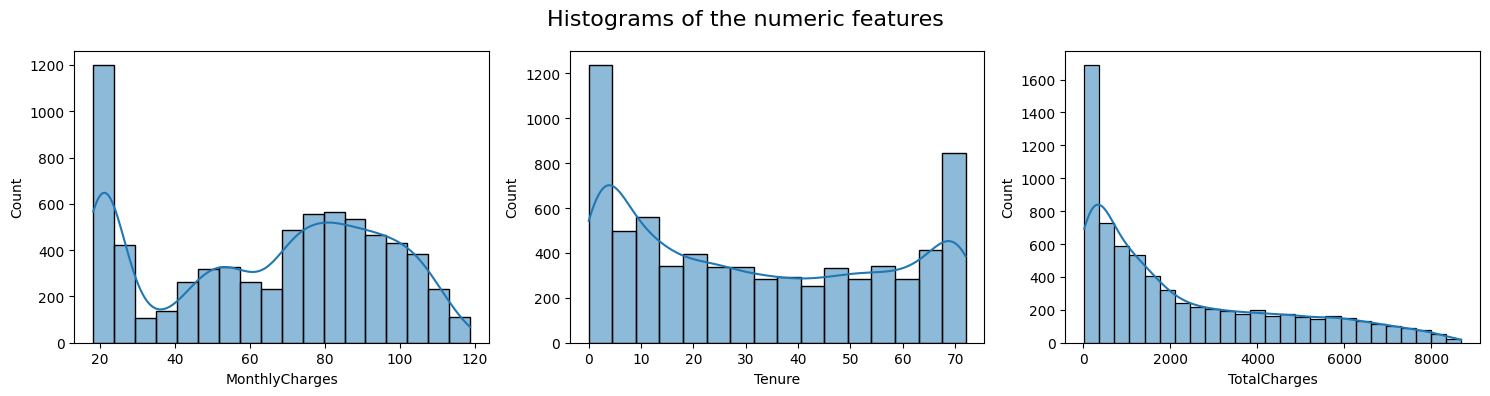

In [23]:
rows, cols = best_grid_shape(len(numeric_features))

fig, axs = plt.subplots(
    rows,
    cols,
    figsize=(5 * cols, 4 * rows),
    tight_layout=True,
)

for ax, column in zip(axs.ravel(), numeric_features):
    sns.histplot(
        data=df,
        x=column,
        ax=ax,
        kde=True,
    )

fig.suptitle("Histograms of the numeric features", fontsize=16)
plt.show()